In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import os
from tqdm import tqdm
import sys
import pandas as pd

In [9]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from tqdm import tqdm


In [1]:
print("Test commencé !")

Test commencé !


In [22]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()  # sortie [-1, 1]
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ])
        self.transform = transform

        if len(self.images) == 0:
            raise RuntimeError(f"Aucune image trouvée dans {image_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMAGE_DIR = "../data/train/degraded_images"   # images sorties du VAE
EPOCHS = 9
BATCH_SIZE = 8
LR = 1e-4


Device: cpu


In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])


In [ ]:
dataset = ImageDataset(IMAGE_DIR, transform)

from torch.utils.data import Subset
import random

MAX_IMAGES = 1000

indices = list(range(len(dataset)))
random.shuffle(indices)
indices = indices[:MAX_IMAGES]

small_dataset = Subset(dataset, indices)

loader = DataLoader(
    small_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

print("Nombre d'images utilisées :", len(small_dataset))


print("Nombre d'images :", len(dataset))


Nombre d'images utilisées : 1000


In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        return torch.relu(x + self.block(x))


In [28]:
model = SimpleCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs in loop:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1} | Loss moyenne: {avg_loss:.4f}")

    torch.save(model.state_dict(), "checkpoints/cnn_last.pth")

print("✅ Entraînement terminé")


Epoch 1/2:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/2: 100%|██████████| 125/125 [06:52<00:00,  3.30s/it, loss=0.0373]


Epoch 1 | Loss moyenne: 0.1267


Epoch 2/2: 100%|██████████| 125/125 [06:10<00:00,  2.96s/it, loss=0.0287]

Epoch 2 | Loss moyenne: 0.0239
✅ Entraînement terminé


In [42]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# --- CHEMINS ---
output_dir = "restored_cnn/"
os.makedirs(output_dir, exist_ok=True)

# --- DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- RECHARGER LE MODELE ---
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("checkpoints/cnn_last.pth", map_location=device))
model.eval()  # mode évaluation

# --- DATALOADER ---
# Si tu veux juste réutiliser le loader que tu avais pour l'entraînement :
loader = DataLoader(
    loader.dataset,  # on reprend le dataset d'entraînement
    batch_size=8,
    shuffle=False
)

# --- BOUCLE DE SAUVEGARDE ---
with torch.no_grad():
    for batch_idx, imgs in enumerate(loader):
        imgs = imgs.to(device)
        restored = model(imgs)

        # Dé-normalisation si nécessaire (ex: [-1,1] -> [0,1])
        restored = (restored + 1) / 2

        for i, img in enumerate(restored):
            save_path = os.path.join(output_dir, f"restored_{batch_idx*8 + i}.png")
            save_image(img, save_path)

print(f"✅ Toutes les images ont été sauvegardées dans {output_dir}")


✅ Toutes les images ont été sauvegardées dans restored_cnn/


In [33]:
class ElegantCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
        )

        self.exit = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.entry(x)
        x = self.res_blocks(x)
        x = self.exit(x)
        return x


In [ ]:
model = ElegantCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs in loop:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1} | Loss moyenne : {avg_loss:.4f}")

    torch.save(model.state_dict(), "checkpoints/elegant_cnn_last.pth")

print("✅ Entraînement terminé")


In [31]:
model.eval()
output_dir = "cnn_outputs2"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, img in enumerate(dataset):
        img = img.unsqueeze(0).to(device)
        out = model(img)

        # dénormalisation [-1,1] → [0,1]
        out = out * 0.5 + 0.5

        utils.save_image(out, os.path.join(output_dir, f"cnn_{i}.png"))

print("✅ Images sauvegardées dans", output_dir)


KeyboardInterrupt: 

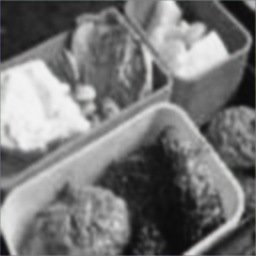

In [30]:
from IPython.display import display

sample_path = os.path.join("cnn_outputs", "cnn_0.png")
display(Image.open(sample_path))


In [35]:
class RestorationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()
        )

        self.out = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        m = self.mid(p2)

        d2 = self.up2(m)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.tanh(self.out(d1))


In [36]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [37]:
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

def cnn_loss(pred, target):
    return criterion_l1(pred, target) + 0.5 * criterion_mse(pred, target)


In [41]:
model = ElegantCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR)

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs in loop:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1} | Loss moyenne : {avg_loss:.4f}")

    torch.save(model.state_dict(), "checkpoints/elegant_cnn_last.pth")

print("✅ Entraînement terminé")


Epoch 1/9: 100%|██████████| 125/125 [37:40<00:00, 18.08s/it, loss=0.0575]


Epoch 1 | Loss moyenne : 0.0884


Epoch 2/9: 100%|██████████| 125/125 [27:06<00:00, 13.02s/it, loss=0.041] 


Epoch 2 | Loss moyenne : 0.0469


Epoch 3/9: 100%|██████████| 125/125 [28:21<00:00, 13.61s/it, loss=0.0256]


Epoch 3 | Loss moyenne : 0.0369


Epoch 4/9: 100%|██████████| 125/125 [37:58<00:00, 18.23s/it, loss=0.0297]


Epoch 4 | Loss moyenne : 0.0346


Epoch 5/9: 100%|██████████| 125/125 [50:37<00:00, 24.30s/it, loss=0.0297]  


Epoch 5 | Loss moyenne : 0.0323


Epoch 6/9: 100%|██████████| 125/125 [35:04<00:00, 16.84s/it, loss=0.0263]


Epoch 6 | Loss moyenne : 0.0307


Epoch 7/9: 100%|██████████| 125/125 [1:23:59<00:00, 40.31s/it, loss=0.0175] 


Epoch 7 | Loss moyenne : 0.0281


Epoch 8/9: 100%|██████████| 125/125 [37:03<00:00, 17.79s/it, loss=0.0226]


Epoch 8 | Loss moyenne : 0.0236


Epoch 9/9: 100%|██████████| 125/125 [32:34<00:00, 15.63s/it, loss=0.0269]

Epoch 9 | Loss moyenne : 0.0242
✅ Entraînement terminé


In [ ]:
dataset = ImageDataset(IMAGE_DIR, transform)

from torch.utils.data import Subset
import random

MAX_IMAGES = 1000

indices = list(range(len(dataset)))
random.shuffle(indices)
indices = indices[:MAX_IMAGES]

small_dataset = Subset(dataset, indices)

loader = DataLoader(
    small_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

print("Nombre d'images utilisées :", len(small_dataset))


print("Nombre d'images :", len(dataset))


Nombre d'images utilisées : 1000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models, utils
from tqdm import tqdm
import os
from PIL import Image

# --- TRANSFORMATIONS ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5,0.5,0.5))
])

# --- DATASET ---
class RestorationDataset(torch.utils.data.Dataset):
    def __init__(self, degraded_dir, clean_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.clean_dir = clean_dir
        self.transform = transform
        degraded_list = os.listdir(degraded_dir)
        clean_list_set = set(os.listdir(clean_dir))
        self.filenames = [f for f in degraded_list if f.replace("degraded_", "") in clean_list_set]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        deg_fn = self.filenames[idx]
        cln_fn = deg_fn.replace("degraded_", "")
        deg = Image.open(os.path.join(self.degraded_dir, deg_fn)).convert("RGB")
        cln = Image.open(os.path.join(self.clean_dir, cln_fn)).convert("RGB")
        seed = torch.seed()
        torch.manual_seed(seed)
        if self.transform:
            deg = self.transform(deg)
        torch.manual_seed(seed)
        if self.transform:
            cln = self.transform(cln)
        return deg, cln

# --- PERCEPTUAL LOSS ---
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights="IMAGENET1K_V1").features[:16].eval()
        for p in vgg.parameters():
            p.requires_grad = False
        self.vgg = vgg
    def forward(self, x, y):
        return nn.functional.l1_loss(self.vgg(x), self.vgg(y))

# --- RESIDUAL BLOCK ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return nn.ReLU(inplace=True)(x + self.block(x))

# --- CNN ELABORE ---
class ElegantCNN(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, n_resblocks=5):
        super().__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.resblocks = nn.Sequential(*[ResidualBlock(base_ch) for _ in range(n_resblocks)])
        self.output_conv = nn.Conv2d(base_ch, in_ch, 3, padding=1)
    def forward(self, x):
        x = self.input_conv(x)
        x = self.resblocks(x)
        x = self.output_conv(x)
        return torch.tanh(x)

# --- HYPERPARAMS ---
BATCH_SIZE = 16       # adapte selon ta VRAM
LR = 1e-3
EPOCHS = 6
NUM_IMAGES = 10000    # images par époque
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_DIR = "checkpoints_elegant"
SAMPLES_DIR = "restored_samples_elegant"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)

# --- DATA LOADERS ---
train_dataset_full = RestorationDataset("../data/train/degraded_images", "../data/train/images", transform)
val_dataset_full = RestorationDataset("../data/test/degraded_images", "../data/test/images", transform)

# On prend juste NUM_IMAGES pour cette session
train_dataset = Subset(train_dataset_full, list(range(min(NUM_IMAGES, len(train_dataset_full)))))
val_dataset = Subset(val_dataset_full, list(range(min(NUM_IMAGES//10, len(val_dataset_full))))) # val plus petit

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- MODEL & LOSS ---
model = ElegantCNN().to(DEVICE)
perceptual = VGGPerceptualLoss().to(DEVICE)
criterion_L1 = nn.L1Loss()
criterion_MSE = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- ENTRAINEMENT ---
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for deg, cln in loop:
        deg, cln = deg.to(DEVICE), cln.to(DEVICE)
        optimizer.zero_grad()
        out = model(deg)
        loss = criterion_L1(out, cln) + 0.5*criterion_MSE(out, cln) + 0.1*perceptual(out, cln)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss moyenne: {avg_loss:.4f}")
    
    # --- Checkpoint ---
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"elegant_epoch{epoch+1}.pth"))

    # --- Sauvegarde échantillons ---
    model.eval()
    with torch.no_grad():
        for i, (deg, cln) in enumerate(val_loader):
            deg = deg.to(DEVICE)
            restored = model(deg)
            for j, img in enumerate(restored):
                utils.save_image((img*0.5 + 0.5), os.path.join(SAMPLES_DIR, f"epoch{epoch+1}_img{i*BATCH_SIZE+j}.png"))
    model.train()

print("✅ Entraînement terminé. Images sauvegardées dans", SAMPLES_DIR)


Epoch 1/6:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\tassili\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
